In [107]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
%matplotlib inline

# ドメイン知識の利用
多くの場合、機械学習の目的は専門家がルールを追加しなくても済むようにすることだが、だからといって、データに対する事前知識(ドメイン知識)をすてるべきではない。  
例えば、航空機の価格を予測するときに日付や航空会社、発着時間を与えられればモデルを作ることもできるだろうが、価格は休暇期間や祝祭日周辺で高価になることを知っていればそれを考慮することでモデルの性能を高めることができるだろう。たとえ祝祭日の特徴量を追加してそれが価格に影響がないとしてもそれがモデルに悪影響を与えることはない。

Citi Bikeのレンタル予測で検証を行う

In [9]:
from mglearn.datasets import load_citibike

citibike = load_citibike()
print('Citi Bike data: {}'.format(citibike.head()))

Citi Bike data: starttime
2015-08-01 00:00:00     3
2015-08-01 03:00:00     0
2015-08-01 06:00:00     9
2015-08-01 09:00:00    41
2015-08-01 12:00:00    39
Freq: 3H, Name: one, dtype: int64


Text(0,0.5,'Rentals')

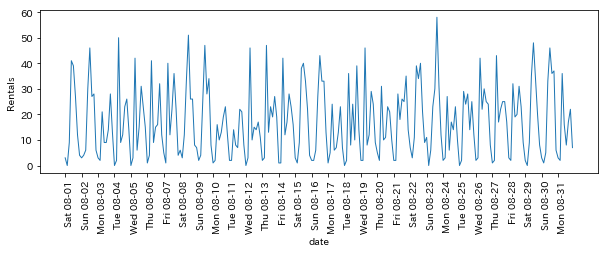

In [10]:
plt.figure(figsize=(10,3))

xticks = pd.date_range(start=citibike.index.min(), end=citibike.index.max(), freq='D')
plt.xticks(xticks, xticks.strftime('%a %m-%d'), rotation=90, ha='left')
plt.plot(citibike, linewidth=1)
plt.xlabel('date')
plt.ylabel('Rentals')

データから24時間単位の昼間と夜間の区別が明確に見て取れる。(昼間に比べて夜間は少ないし、平日に比べて週末は多い)  
このような時系列に対する予測タスクでは**過去から学習(learn from the past)と未来を予測(predict for the future)**のアプローチをとる。つまり訓練セットとテストセットを分割する際にある特定の日までをすべてを訓練セットとして、それ以降をテストセットとするわけである。過去のレンタル履歴から未来のレンタル履歴を予測することは直感的に行なっていることだ。  

今回は最初の23日分の184データポイントを訓練セットとして残り8日分の64データポイントをテストセットとする。  
また今回の予測タスクにおいて使用する特徴量は特定のレンタルが発生した際の日時だけだ。たとば2015-08-01 00:00:00のような日時で、出力はその後の3時間のレンタル数となる。

In [11]:
#ターゲットの抽出
y = citibike.values
#時刻POSIX時刻に変換
X = citibike.index.astype("int64").values.reshape(-1, 1) // 10**9

In [32]:
#最初の184のデータセットを訓練データに使用する
n_train = 184

#与えられた特徴量セットでモデルを評価してプロットする
def eval_on_features(features, target, regressor):
    #データセットの分割
    X_train, X_test = features[:n_train], features[n_train:]
    #ターゲットの分割
    y_train, y_test = target[:n_train], target[n_train:]
    
    regressor.fit(X_train, y_train)
    print('Test set R^2: {:,.2f}'.format(regressor.score(X_test, y_test)))
    y_pred = regressor.predict(X_test)
    y_pred_train = regressor.predict(X_train)
    
    plt.figure(figsize=(10,3))
    plt.xticks(range(0, len(X), 8), xticks.strftime('%a %m-%d'), rotation=90, ha='left')
    plt.plot(range(n_train), y_train, label='train')
    plt.plot(range(n_train, len(y_test) + n_train), y_test, '-', label='test')
    plt.plot(range(n_train), y_pred_train, '--', label='prediction train')
    plt.plot(range(n_train, len(y_test) + n_train) ,y_pred, '--', label='prediction test')
    plt.legend(loc=(1.01, 0))
    plt.xlabel('Date')
    plt.ylabel('Rentals')


Test set R^2: -0.04


<Figure size 432x288 with 0 Axes>

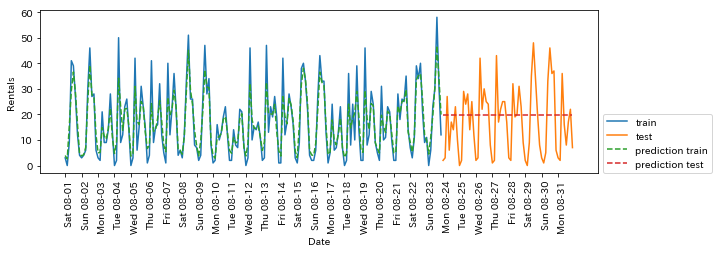

In [33]:
regressor = RandomForestRegressor(n_estimators=100, random_state=0)
plt.figure()
eval_on_features(X, y, regressor)

ランダムフォレストではいつものことだが、訓練セットに対する予測は非常によい。しかし、テストセットに対しては定数の線がよそくされてしまっている。スコアも-0.04と非常に悪い。  
**問題は特徴量とランダムフォレストの組合せにある。**テストセットのPOSIX時刻の特徴量の値は訓練セットの特徴量のレンジを外れている(なぜなら過去から未来を予測するためにそう意図的にしたからだ)。決定木は訓練セットのレンジの外にまでデータを外挿できないことを思い出そう。  
ここでドメイン知識を導入する。図から1日の時間帯と曜日が重要な特徴量であることがわかるのでこれを特徴量に追加する。まずは時間次に曜日と段階で検証してみる

Test set R^2: 0.60


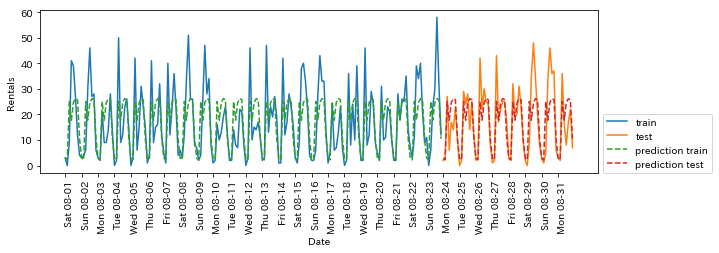

In [35]:
X_hour = citibike.index.hour.values.reshape(-1,1)
eval_on_features(X_hour, y, regressor)

R^2値ははるかによくなっている。ただしやはり曜日のピークまでは再現できていないことがわかる。

Test set R^2: 0.84


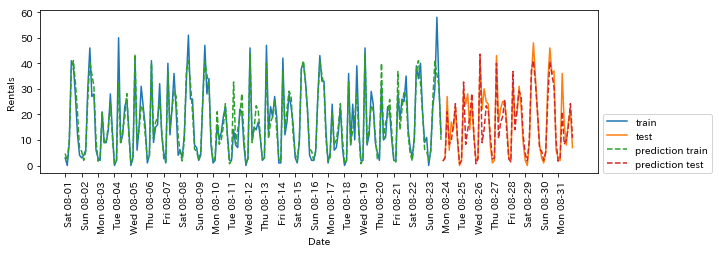

In [37]:
X_hour_week = np.hstack([citibike.index.dayofweek.values.reshape(-1,1), citibike.index.hour.values.reshape(-1,1)])
eval_on_features(X_hour_week, y, regressor)

曜日と時間帯を考慮した周期パターンを捉えることができた。$R^{2}$スコアも改善していることがわかる。**このモデルが学習するのは、8月最初のから23日までの曜日と時刻の組み合わせによる平均レンタル数である。**これにはランダムフォレストのような複雑なモデルは必要ではないはずなので線形モデルで再現できないか検証してみる

Test set R^2: 0.13


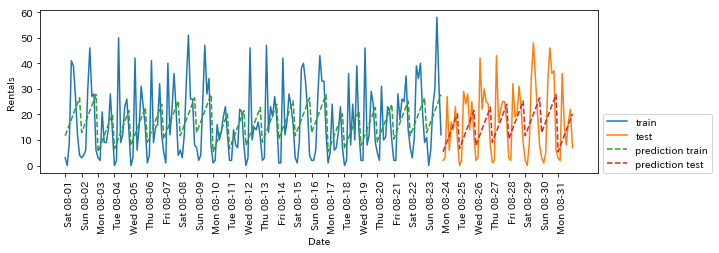

In [38]:
from sklearn.linear_model import LinearRegression
eval_on_features(X_hour_week, y, LinearRegression())

線形モデルの性能はずっと悪く、周期もおかしい。  
これは曜日や時刻が整数でエンコードされていて、連続値として解釈されているからだ(ビニングで線形モデルの性能が上昇したことを思い出そう)。線形モデルは時刻に対して線形関数として学習できていないので、時刻が遅いほどレンタル数が多くなるとしか予測できていない。  
時刻をOneHotEncordingしてカテゴリ変数とすれば、パターンを捉えることができる。

In [41]:
from sklearn.preprocessing import OneHotEncoder

enc = OneHotEncoder()
X_hour_week_enc = enc.fit_transform(X_hour_week).toarray()

Test set R^2: 0.61


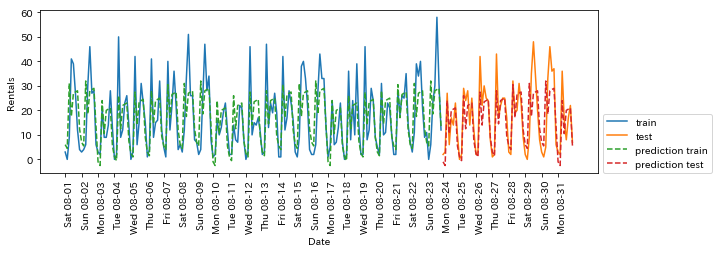

In [42]:
eval_on_features(X_hour_week_enc, y, LinearRegression())

特徴量を連続値として入力した場合と比較して、周期をより捉えていることがわかる。ここでは線形モデルは曜日と時刻を別々に捉えているので、時刻に対するパターンはすべての曜日対して同じものになっている(月曜でも日曜でも同じ時刻パターンで区別していない)。  
曜日と時刻を組合せた交互作用特徴量を導入することで曜日と時刻に特徴的なパターンも捉えることができる

Test set R^2: 0.85


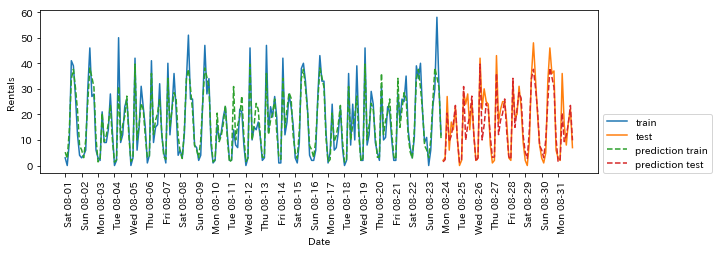

In [44]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Ridge

poly_transformer = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
X_hour_week_enc_ploy = poly_transformer.fit_transform(X_hour_week_enc)

lr = Ridge()
eval_on_features(X_hour_week_enc_ploy, y, lr)

これでランダムフォレストと同等の性能である。  
このモデルの利点は何を学習したか明確な点である。曜日と時刻の組合せに対して係数がひとつづつだからだ。
このモデルが学習した係数をプロットしてみる。これはランダムフォレストにはできない。

In [48]:
hour = ["%02d:00" % i for i in range(0, 24,3)]
hour

['00:00', '03:00', '06:00', '09:00', '12:00', '15:00', '18:00', '21:00']

In [51]:
day = ['Mon', 'Tue','Wed','Thu', 'Fri', 'Sat', 'Sun']
features = day + hour
features

['Mon',
 'Tue',
 'Wed',
 'Thu',
 'Fri',
 'Sat',
 'Sun',
 '00:00',
 '03:00',
 '06:00',
 '09:00',
 '12:00',
 '15:00',
 '18:00',
 '21:00']

In [52]:
features_poly =poly_transformer.get_feature_names(features)
features_poly

['Mon',
 'Tue',
 'Wed',
 'Thu',
 'Fri',
 'Sat',
 'Sun',
 '00:00',
 '03:00',
 '06:00',
 '09:00',
 '12:00',
 '15:00',
 '18:00',
 '21:00',
 'Mon Tue',
 'Mon Wed',
 'Mon Thu',
 'Mon Fri',
 'Mon Sat',
 'Mon Sun',
 'Mon 00:00',
 'Mon 03:00',
 'Mon 06:00',
 'Mon 09:00',
 'Mon 12:00',
 'Mon 15:00',
 'Mon 18:00',
 'Mon 21:00',
 'Tue Wed',
 'Tue Thu',
 'Tue Fri',
 'Tue Sat',
 'Tue Sun',
 'Tue 00:00',
 'Tue 03:00',
 'Tue 06:00',
 'Tue 09:00',
 'Tue 12:00',
 'Tue 15:00',
 'Tue 18:00',
 'Tue 21:00',
 'Wed Thu',
 'Wed Fri',
 'Wed Sat',
 'Wed Sun',
 'Wed 00:00',
 'Wed 03:00',
 'Wed 06:00',
 'Wed 09:00',
 'Wed 12:00',
 'Wed 15:00',
 'Wed 18:00',
 'Wed 21:00',
 'Thu Fri',
 'Thu Sat',
 'Thu Sun',
 'Thu 00:00',
 'Thu 03:00',
 'Thu 06:00',
 'Thu 09:00',
 'Thu 12:00',
 'Thu 15:00',
 'Thu 18:00',
 'Thu 21:00',
 'Fri Sat',
 'Fri Sun',
 'Fri 00:00',
 'Fri 03:00',
 'Fri 06:00',
 'Fri 09:00',
 'Fri 12:00',
 'Fri 15:00',
 'Fri 18:00',
 'Fri 21:00',
 'Sat Sun',
 'Sat 00:00',
 'Sat 03:00',
 'Sat 06:00',
 'Sat 09:0

In [53]:
features_nonzero = np.array(features_poly)[lr.coef_ !=0]
coef_nonzero = lr.coef_[lr.coef_ !=0]

Text(0,0.5,'Feature magnitude')

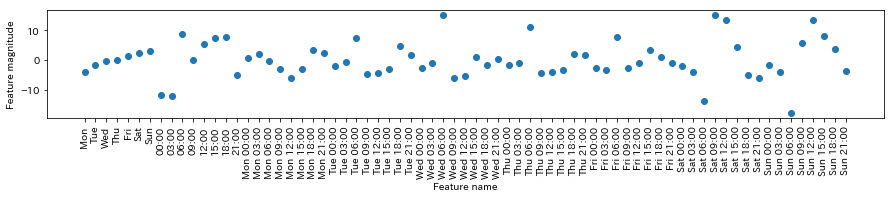

In [55]:
plt.figure(figsize=(15,2))
plt.plot(coef_nonzero, 'o')
plt.xticks(np.arange(len(coef_nonzero)), features_nonzero, rotation=90)
plt.xlabel('Feature name')
plt.ylabel('Feature magnitude')

週末にかけて係数が増大している。時間帯は06：00がピーク。
曜日と時間帯の組合せで係数のピークと、実際のピークがよく似ていることもわかる

## さらなる考察
本ではFeature Enginerringの側面からテストデータにfitさせる方法を学んだ。大体のコンペや実用の範囲では交差検証を用いて、訓練データ内でのfit具合もみるはずである。どんな風に交差検証を構築すればいいかを考察する。

In [109]:
data = pd.DataFrame(
    {
        'timestamp':citibike.index,
        'target': y
    }
)

In [110]:
#trainとtestの分割の方法は変わらない。
n_train = 184

In [111]:
#特徴量を生成
def make_date_feature(df):
    df['day'] = df['timestamp'].dt.day
    df['hour'] = df['timestamp'].dt.hour
    df['dayofweek'] = df['timestamp'].dt.dayofweek
    
    return df
    
data = make_date_feature(data)

### 交差検証にkfoldを用いる

In [154]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
kfold = KFold(n_splits=3, shuffle=True, random_state=0)

In [155]:
#データセットの分割
df_train, df_test = data.iloc[:n_train].copy(), data.iloc[n_train:].copy()

#timestampの削除
df_train.drop('timestamp', axis=1, inplace=True)
df_test.drop('timestamp', axis=1, inplace=True)

In [156]:
X_train = df_train[['day', 'hour', 'dayofweek']]
y_train = df_train['target']
X_test = df_test[['day', 'hour', 'dayofweek']]
y_test = df_test['target']

In [157]:
rfreg = RandomForestRegressor(n_estimators=100,random_state=0)
scores=cross_val_score(rfreg, X_train, y_train, cv=kfold)
print('validation scores: {}'.format(scores))
print('validation scores mean: {}'.format(np.mean(scores)))

validation scores: [0.72252773 0.7562482  0.70850898]
validation scores mean: 0.7290949698585196


In [158]:
print('Test Score: {}'.format(rfreg.fit(X_train, y_train).score(X_test, y_test)))

Test Score: 0.7967714739993303


cross-validationのスコアと最終的なテストスコアで乖離が大きいことがわかる。時系列データにshuffleしたkfold分割は向かない

In [159]:
kfold = KFold(n_splits=3, shuffle=False, random_state=0)
rfreg = RandomForestRegressor(n_estimators=100,random_state=0)
scores = cross_val_score(rfreg, X_train, y_train, cv=kfold)
print('validation scores: {}'.format(scores))
print('validation scores mean: {}'.format(np.mean(scores)))

validation scores: [0.76643094 0.81051152 0.6515312 ]
validation scores mean: 0.7428245551485908


In [160]:
print('Test Score: {}'.format(rfreg.fit(X_train, y_train).score(X_test, y_test)))

Test Score: 0.7967714739993303


In [135]:
for train_idx, valid_idx in kfold.split(X_train, y_train):
    print('train_idx: {}'.format(train_idx))
    print('valid_idx: {}'.format(valid_idx))

train_idx: [ 62  63  64  65  66  67  68  69  70  71  72  73  74  75  76  77  78  79
  80  81  82  83  84  85  86  87  88  89  90  91  92  93  94  95  96  97
  98  99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115
 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133
 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151
 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169
 170 171 172 173 174 175 176 177 178 179 180 181 182 183]
valid_idx: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61]
train_idx: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61 123 124 125 126 127 128 129 1

単純な分割でも3分割目(0-122訓練で123-183を検証)で大きくスコアが下がっていることがわかる。  
これならsuffleした方が検証スコアのばらつきは小さい気がするが、平均すると、シャッフルなしの方がscoreは良い。

In [190]:
from sklearn.model_selection import TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=3)

for fold_, (train_idx, valid_idx) in enumerate(tscv.split(X_train, y_train)):
    print('fold: {}'.format(fold_))
    print('train_idx: {}'.format(train_idx))
    print('valid_idx: {}'.format(valid_idx))

fold: 0
train_idx: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45]
valid_idx: [46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69
 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91]
fold: 1
train_idx: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91]
valid_idx: [ 92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108 109
 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127
 128 129 130 131 132 133 134 135 136 137]
fold: 2
train_idx: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41

In [191]:
rfreg = RandomForestRegressor(n_estimators=100,random_state=0)
scores = cross_val_score(rfreg, X_train, y_train, cv=tscv)
print('validation scores: {}'.format(scores))
print('validation scores mean: {}'.format(np.mean(scores)))

validation scores: [0.52488929 0.81880498 0.70968879]
validation scores mean: 0.6844610169039188


In [192]:
print('Test Score: {}'.format(rfreg.fit(X_train, y_train).score(X_test, y_test)))

Test Score: 0.7967714739993303


TimeSeriesSplitでもCVの平均は実際のスコアとの乖離がある。